# TFM

In [1]:
# IMPORT LIBRAIES
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, make_scorer
import time as t
# Visualize 
import matplotlib.pyplot as plt




#TREE
from sklearn.tree import DecisionTreeClassifier
#RandomForest
from sklearn.ensemble import RandomForestClassifier
#KNN
from sklearn.neighbors import KNeighborsClassifier



In [21]:
model_evaluations={}

## DATA PREPARATION

In [2]:
# Read the CSV file
df = pd.read_csv('dataset_TFM.csv')  # Replace 'your_dataset.csv' with the path to your dataset


The data set contains 87 extracted features, the column with the url, and the status column. Features are from three different classes: 56 extracted from the structure and syntax of URLs, 24 extracted from the content of their correspondent pages and 7 are extracetd by querying external services.

In [3]:
print(len(df.columns))
df.columns

89


Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

In [4]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [5]:
df_complete = df
content_features = ['nb_hyperlinks','ratio_intHyperlinks','ratio_extHyperlinks','ratio_nullHyperlinks',
    'nb_extCSS','ratio_intRedirection','ratio_extRedirection','ratio_intErrors','ratio_extErrors',
    'login_form','external_favicon','links_in_tags','submit_email','ratio_intMedia','ratio_extMedia',
    'sfh','iframe','popup_window','safe_anchor','onmouseover','right_clic','empty_title',
    'domain_in_title','domain_with_copyright']

external_features = ['whois_registered_domain','domain_registration_length','domain_age',
    'web_traffic','dns_record','google_index','page_rank']

df.drop(content_features, axis=1, inplace=True)
df.drop(external_features, axis=1, inplace=True)

print(len(df.columns))


58


In [6]:
# Define a dictionary to map string values to binary values
status_mapping = {'phishing': 0, 'legitimate': 1}

# Map the 'status' variable using the dictionary
df['status'] = df['status'].map(status_mapping)


In [7]:
df.columns

Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

# EDA


In [8]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   url                      11430 non-null  object 
 1   length_url               11430 non-null  int64  
 2   length_hostname          11430 non-null  int64  
 3   ip                       11430 non-null  int64  
 4   nb_dots                  11430 non-null  int64  
 5   nb_hyphens               11430 non-null  int64  
 6   nb_at                    11430 non-null  int64  
 7   nb_qm                    11430 non-null  int64  
 8   nb_and                   11430 non-null  int64  
 9   nb_or                    11430 non-null  int64  
 10  nb_eq                    11430 non-null  int64  
 11  nb_underscore            11430 non-null  int64  
 12  nb_tilde                 11430 non-null  int64  
 13  nb_percent               11430 non-null  int64  
 14  nb_slash

In [9]:
# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())



Summary Statistics:
         length_url  length_hostname            ip       nb_dots  \
count  11430.000000     11430.000000  11430.000000  11430.000000   
mean      61.126684        21.090289      0.150569      2.480752   
std       55.297318        10.777171      0.357644      1.369686   
min       12.000000         4.000000      0.000000      1.000000   
25%       33.000000        15.000000      0.000000      2.000000   
50%       47.000000        19.000000      0.000000      2.000000   
75%       71.000000        24.000000      0.000000      3.000000   
max     1641.000000       214.000000      1.000000     24.000000   

         nb_hyphens         nb_at         nb_qm        nb_and    nb_or  \
count  11430.000000  11430.000000  11430.000000  11430.000000  11430.0   
mean       0.997550      0.022222      0.141207      0.162292      0.0   
std        2.087087      0.155500      0.364456      0.821337      0.0   
min        0.000000      0.000000      0.000000      0.000000      0.0

In [10]:
# Get the number of unique values for each column
unique_counts = df.nunique()

# Display the number of unique values for each column
print("Number of unique values for each column:")
print(unique_counts)

Number of unique values for each column:
url                        11429
length_url                   324
length_hostname               83
ip                             2
nb_dots                       19
nb_hyphens                    27
nb_at                          5
nb_qm                          4
nb_and                        15
nb_or                          1
nb_eq                         16
nb_underscore                 17
nb_tilde                       2
nb_percent                    25
nb_slash                      22
nb_star                        2
nb_colon                       6
nb_comma                       5
nb_semicolumn                 15
nb_dollar                      5
nb_space                       9
nb_www                         3
nb_com                         7
nb_dslash                      2
http_in_path                   5
https_token                    2
ratio_digits_url            1414
ratio_digits_host            241
punycode                       2
po

The column 'nb_or' has only the value 0.

In [11]:
df=df.drop('nb_or',axis =1)

In [12]:
numerical_features = [
    'length_url', 'length_hostname', 'nb_dots', 'nb_hyphens', 'nb_at', 
    'nb_underscore', 'nb_percent', 'nb_slash', 'ratio_digits_url', 'nb_star','nb_colon',
    'ratio_digits_host', 'nb_subdomains', 'shortest_words_raw', 'length_words_raw',
    'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 
    'longest_word_host', 'longest_word_path', 'avg_words_raw', 'char_repeat',
    'avg_word_host', 'avg_word_path','nb_qm', 'nb_and', 'nb_eq', 'nb_tilde', 'nb_comma', 
    'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 
    'nb_dslash','nb_external_redirection','nb_redirection']
print(len(numerical_features))
df[numerical_features].nunique()

37


length_url                  324
length_hostname              83
nb_dots                      19
nb_hyphens                   27
nb_at                         5
nb_underscore                17
nb_percent                   25
nb_slash                     22
ratio_digits_url           1414
nb_star                       2
nb_colon                      6
ratio_digits_host           241
nb_subdomains                 3
shortest_words_raw           25
length_words_raw             54
shortest_word_host           34
shortest_word_path           33
longest_words_raw           119
longest_word_host            49
longest_word_path           120
avg_words_raw               896
char_repeat                  55
avg_word_host               174
avg_word_path               757
nb_qm                         4
nb_and                       15
nb_eq                        16
nb_tilde                      2
nb_comma                      5
nb_semicolumn                15
nb_dollar                     5
nb_space

In [13]:
categorical_features = [
    'ip',  'http_in_path', 'https_token', 'punycode', 'tld_in_path', 
    'tld_in_subdomain', 'abnormal_subdomain', 'prefix_suffix', 
    'random_domain', 'shortening_service', 'phish_hints', 'port', 
    'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 
    'suspecious_tld', 'statistical_report','path_extension', 'status']
print(len(categorical_features))
df[categorical_features].nunique()

19


ip                    2
http_in_path          5
https_token           2
punycode              2
tld_in_path           2
tld_in_subdomain      2
abnormal_subdomain    2
prefix_suffix         2
random_domain         2
shortening_service    2
phish_hints           9
port                  2
domain_in_brand       2
brand_in_subdomain    2
brand_in_path         2
suspecious_tld        2
statistical_report    3
path_extension        2
status                2
dtype: int64

The total numer of features is 57 including the feature 'url' that contains the text of the path so it is not a numerical nor categorical feature.

In [14]:
len(numerical_features)+len(categorical_features)


56

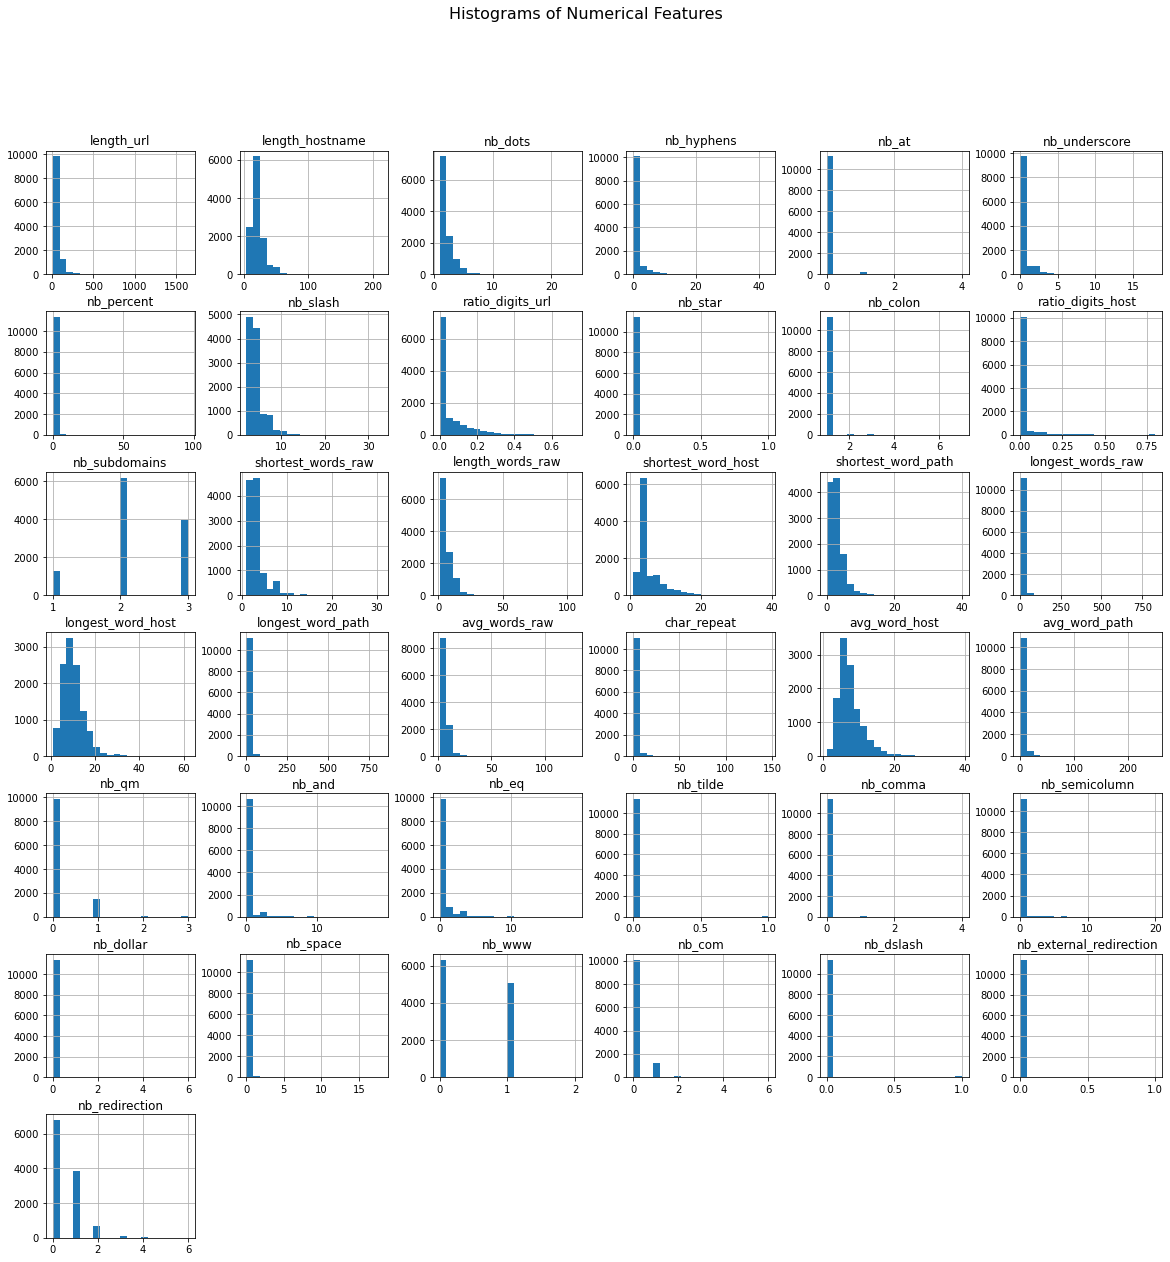

In [110]:
df[numerical_features].hist(bins=20, figsize=(20, 20))
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

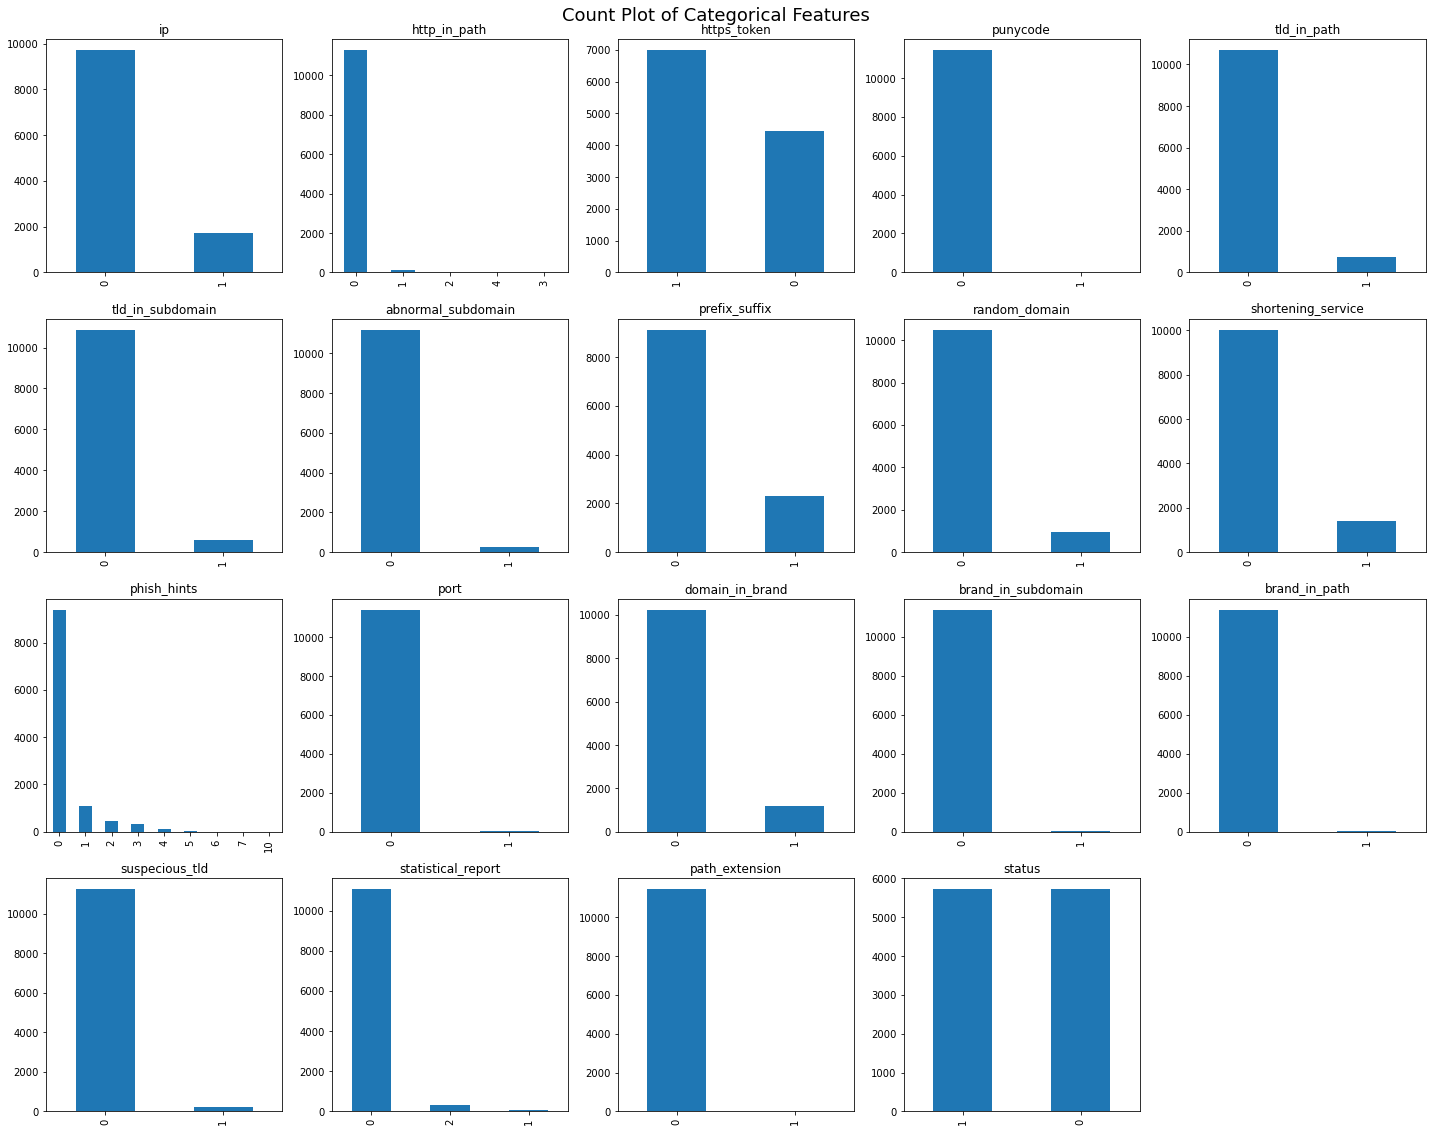

In [105]:
# Assuming df is your DataFrame and categorical_features is your list of categorical features
cat_features = len(categorical_features)
num_rows = (cat_features + 4) // 5  # Calculate number of rows needed

plt.figure(figsize=(20, 4 * num_rows))  # Adjust the figure size

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(num_rows, 5, i)  # Adjust the number of columns to 5
    df[feature].value_counts().plot(kind='bar', title=feature)

plt.suptitle("Count Plot of Categorical Features", fontsize=18)
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

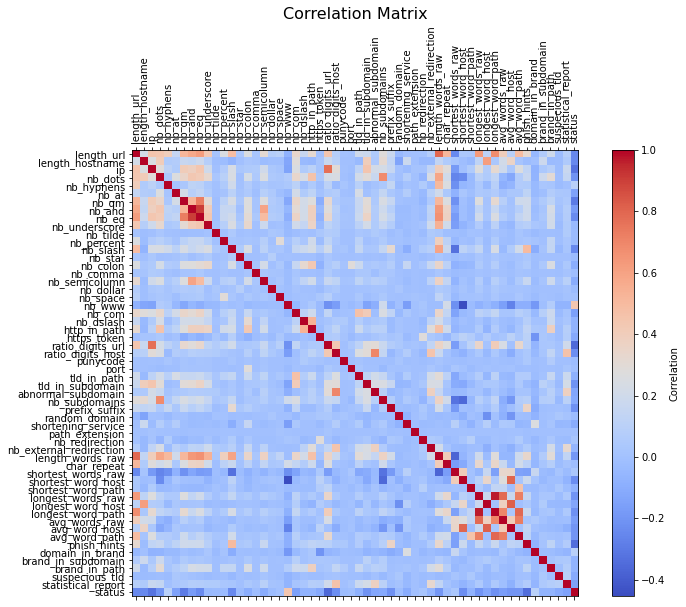

In [111]:
# Correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar(label='Correlation', aspect=20)
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

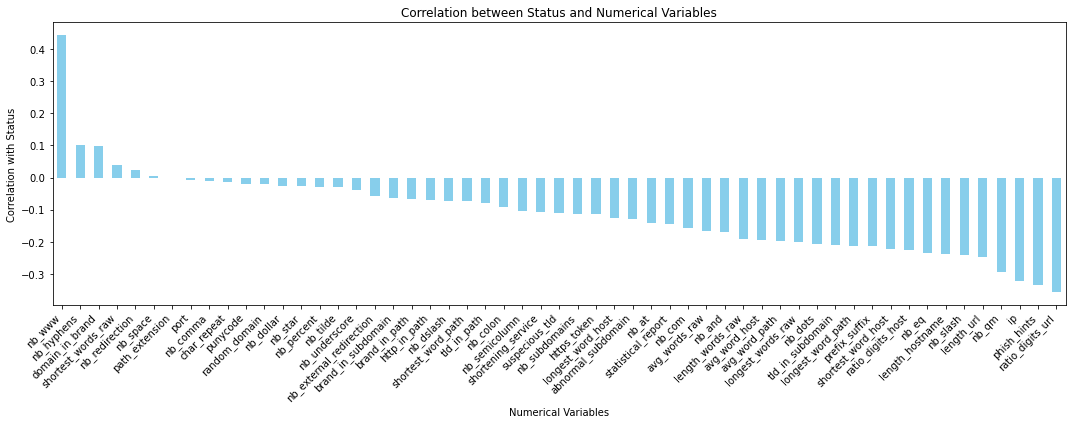

In [112]:

# Calculate correlation with status
correlation_with_status = df.corr()['status'].drop('status')

# Sort correlations in descending order
correlation_with_status_sorted = correlation_with_status.sort_values(ascending=False)

# Plot bar plot
plt.figure(figsize=(15, 6))
correlation_with_status_sorted.plot(kind='bar', color='skyblue')
plt.title('Correlation between Status and Numerical Variables')
plt.xlabel('Numerical Variables')
plt.ylabel('Correlation with Status')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
nb_space, path_extension, port, nb_redirection nb_comma

### Split the data

In [15]:
# Split the data into features (X) and target variable (y)
X = df.drop('url', axis=1)
X = X.drop('status', axis=1)  # Features
y = df['status']  # Target variable

# Random state
rs = 123

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)


In [16]:
# Select columns with object (string) data type
string_columns = X.select_dtypes(include=['object'])

# Check if there are any string columns
if not string_columns.empty:
    print("String columns:")
    print(string_columns.columns)
else:
    print("No string columns found.")


No string columns found.


## DECISION TREE

In [17]:
class DecisionTree:

    def __init__(self, max_depth=None, min_samples_split=2, max_features=None, criterion='entropy'):
        '''
        Initialize the decision tree
        :param max_depth: maximum depth of the tree
        :param min_samples_split: minimum number of samples required for a split
        :param random_state: random state
        :param criterion: measure function to use for best_partition, default to entropy
        '''

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.criterion = criterion
        self.tree = None

    def fit(self, X_train, y_train):
        '''
        Fit the decision tree to the training data.
        :param X: training features
        :param y: training labels
        '''
        self.tree = DecisionTreeClassifier(
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            max_features=self.max_features,
            random_state= rs
        )
        self.tree.fit(X_train, y_train)

    def predict(self, X_train):
        '''
        Make predictions using the trained decision tree.
        :param X: features of the data to be predicted
        :return: array of predicted labels
        '''
        if self.tree is None:
            raise ValueError("Decision tree has not been trained yet. Call fit() first.")

        predictions = self.tree.predict(X_train)
        return predictions



### HPO for decision tree

In [18]:
# Define the parameters grid to search
param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion':['gini','entropy']
}

# Define the scoring metric
scorer = make_scorer(accuracy_score)

# Instantiate the decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=rs)

# Instantiate GridSearchCV
grid_search = GridSearchCV(decision_tree, param_grid, scoring=scorer, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found:", best_params)
print("Best accuracy score:", best_score)


Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_split': 10}
Best accuracy score: 0.8696401759639555


### Evaluation of Decision tree

In [19]:
# Instantiate the DecisionTree object with desired parameters
decision_tree_model = DecisionTree(max_depth=None, min_samples_split=10, max_features=None, criterion='entropy')

# Fit the model to the training data
decision_tree_model.fit(X_train, y_train)

start_time = t.time()

# Make predictions on the test data
predictions = decision_tree_model.predict(X_test)

# Calculate time taken
end_time = t.time()
time = end_time - start_time


# Evaluate the model
dt_accuracy = accuracy_score(y_test, predictions)
dt_precision = precision_score(y_test, predictions)
dt_recall = recall_score(y_test, predictions)
dt_f1 = f1_score(y_test, predictions)


print("Test accuracy:", dt_accuracy)
print("Test precision:", dt_precision)
print("Test recall:", dt_recall)
print("Test f1 score:", dt_f1)

Test accuracy: 0.8797025371828522
Test precision: 0.8882575757575758
Test recall: 0.85662100456621
Test f1 score: 0.8721524872152486


In [22]:
# Store results in the dictionary
model_evaluations['DecisionTree'] = {
        "accuracy": dt_accuracy,
        "precision": dt_precision,
        "recall": dt_recall,
        "f1": dt_f1,
        "predicting time": time}

In [23]:
model_evaluations

{'DecisionTree': {'accuracy': 0.8797025371828522,
  'precision': 0.8882575757575758,
  'recall': 0.85662100456621,
  'f1': 0.8721524872152486,
  'predicting time': 0.004766225814819336}}

## RANDOM FOREST

In [127]:
class RandomForest:

    def __init__(self, n_estimators=100, max_depth=None, criterion=None,max_features=None):
        '''
        Initialize the Random Forest model
        :param n_estimators: The number of trees in the forest
        :param max_depth: The maximum depth of the tree
        :param random_state: Controls both the randomness of the bootstrapping of the samples used when building trees
                              (if `bootstrap=True`) and the sampling of the features to consider when looking for the best split at each node.
        :param criterion:
        :param max_features:
        '''
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.criterion = criterion
        self.max_features = max_features
        self.rf = None
        self.feature_importance_scores = None


    def fit(self, X_train, y_train):
        '''
        Fit the Random Forest model to the training data
        :param X_train: The training features
        :param y_train: The training labels
        '''
        self.rf = RandomForestClassifier(n_estimators=self.n_estimators, criterion= self.criterion,
                                             max_depth=self.max_depth, max_features=self.max_features,
                                             random_state= rs)
        self.rf.fit(X_train, y_train)
        self.feature_importance_scores = self.rf.feature_importances_
        
    def predict(self, X_test):
        '''
        Make predictions using the trained Random Forest model
        :param X_test: The test features
        :return: Predicted labels
        '''
        if self.rf is None:
            raise ValueError("Random Forest model has not been trained yet. Call fit() first.")
        return self.rf.predict(X_test)

    

### HPO for RandomForest

In [128]:
# Define the hyperparameters grid to search
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],         # Maximum depth of the trees
    'criterion': ['gini', 'entropy'],  # Split criterion
    'max_features': ['auto', 'sqrt']   # Maximum number of features considered for splitting
}


In [130]:
#Initiate the RandomForestModel
random_forest_model = RandomForestClassifier(random_state = rs)

# Instantiate GridSearchCV
grid_search_rf = GridSearchCV(random_forest_model, param_grid_rf, cv=5)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_

print("Best parameters found:", best_params)
print("Best accuracy score:", best_score)


Best parameters found: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
Best accuracy score: 0.9027765049596042


### Evaluation of Random forest

In [139]:
# Instantiate the DecisionTree object with desired parameters
rf_model = RandomForest(max_depth=None, n_estimators=200, max_features='auto', criterion='gini')

# Fit the model to the training data
rf_model.fit(X_train, y_train)

start_time = t.time()

# Make predictions on the test data
predictions = rf_model.predict(X_test)

# Calculate time taken
end_time = t.time()
time = end_time - start_time


# Evaluate the model
rf_accuracy = accuracy_score(y_test, predictions)
rf_precision = precision_score(y_test, predictions)
rf_recall = recall_score(y_test, predictions)
rf_f1 = f1_score(y_test, predictions)


print("Test accuracy:", rf_accuracy)
print("Test precision:", rf_precision)
print("Test recall:", rf_recall)
print("Test f1 score:", rf_f1)

Test accuracy: 0.9181977252843394
Test precision: 0.9203703703703704
Test recall: 0.9077625570776255
Test f1 score: 0.9140229885057473


In [140]:
# Store results in the dictionary
model_evaluations['RandomForest_all'] = {
        "accuracy": rf_accuracy,
        "precision": rf_precision,
        "recall": rf_recall,
        "f1": rf_f1,
        "predicting time": time}

In [141]:
model_evaluations

{'RandomForest_all': {'accuracy': 0.9181977252843394,
  'precision': 0.9203703703703704,
  'recall': 0.9077625570776255,
  'f1': 0.9140229885057473,
  'predicting time': 0.1452169418334961}}

In [132]:
# Access feature importance scores
feature_importance_scores = rf_model.feature_importance_scores

feature_names = X_train.columns

# Rank features
sorted_indices = feature_importance_scores.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
print("Ranked features by importance:")
for i, feature in enumerate(sorted_features):
    print(f"{i+1}. {feature}")

Ranked features by importance:
1. nb_www
2. phish_hints
3. longest_word_path
4. ratio_digits_url
5. length_url
6. length_hostname
7. longest_words_raw
8. char_repeat
9. shortest_word_host
10. length_words_raw
11. nb_hyphens
12. avg_word_path
13. nb_slash
14. avg_words_raw
15. avg_word_host
16. nb_dots
17. ratio_digits_host
18. longest_word_host
19. ip
20. shortest_words_raw
21. shortest_word_path
22. nb_redirection
23. domain_in_brand
24. https_token
25. nb_subdomains
26. nb_underscore
27. nb_qm
28. nb_eq
29. prefix_suffix
30. shortening_service
31. suspecious_tld
32. random_domain
33. statistical_report
34. nb_com
35. nb_and
36. tld_in_path
37. nb_percent
38. tld_in_subdomain
39. nb_at
40. nb_space
41. nb_colon
42. abnormal_subdomain
43. http_in_path
44. nb_tilde
45. nb_semicolumn
46. nb_dslash
47. brand_in_path
48. port
49. nb_comma
50. brand_in_subdomain
51. punycode
52. nb_external_redirection
53. path_extension
54. nb_dollar
55. nb_star


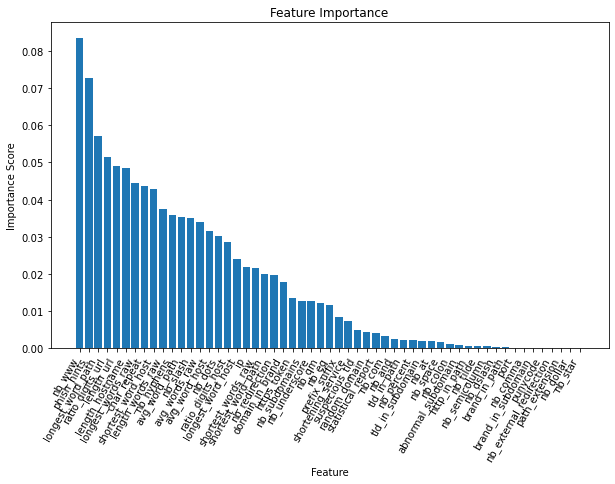

In [133]:
# Sort feature importance scores and feature names
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Assuming you have feature names stored in a list called feature_names
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance_scores)),sorted(feature_importance_scores,reverse=True), tick_label=sorted_feature_names)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.xticks(rotation=60, ha='right')
plt.show()

In [153]:
X_train_20important = X_train[sorted_feature_names[:20]]
X_test_20important = X_test[sorted_feature_names[:20]]

In [154]:
# Instantiate the DecisionTree object with desired parameters
rf_model = RandomForest(max_depth=None, n_estimators=200, max_features='auto', criterion='gini')

# Fit the model to the training data
rf_model.fit(X_train_20important, y_train)

start_time = t.time()

# Make predictions on the test data
predictions = rf_model.predict(X_test_20important)

# Calculate time taken
end_time = t.time()
time = end_time - start_time


# Evaluate the model
rf_accuracy2 = accuracy_score(y_test, predictions)
rf_precision2 = precision_score(y_test, predictions)
rf_recall2 = recall_score(y_test, predictions)
rf_f12 = f1_score(y_test, predictions)


print("Test accuracy:", rf_accuracy2)
print("Test precision:", rf_precision2)
print("Test recall:", rf_recall2)
print("Test f1 score:", rf_f12)

Test accuracy: 0.8963254593175853
Test precision: 0.8979591836734694
Test recall: 0.8840182648401826
Test f1 score: 0.8909341923607916


In [155]:
model_evaluations['RandomForest_top20'] = {
        "accuracy": rf_accuracy2,
        "precision": rf_precision2,
        "recall": rf_recall2,
        "f1": rf_f12,
        "predicting time": time}

In [156]:
model_evaluations

{'RandomForest_all': {'accuracy': 0.9181977252843394,
  'precision': 0.9203703703703704,
  'recall': 0.9077625570776255,
  'f1': 0.9140229885057473,
  'predicting time': 0.1452169418334961},
 'RandomForest_top20': {'accuracy': 0.8963254593175853,
  'precision': 0.8979591836734694,
  'recall': 0.8840182648401826,
  'f1': 0.8909341923607916,
  'predicting time': 0.09335494041442871}}

## K-NEAREST NEIGHBORS





In [35]:

class KNNModel:
    def __init__(self, n_neighbors, weights='uniform', algorithm='auto',p=2):
        '''
        Initialize the KNN model
        :param n_neighbors: Number of neighbors to use
        :param weights: Weight function used in prediction
        :param algorithm: Algorithm used to compute the nearest neighbors
        :param p: Power parameter for the Minkowski metric. When p = 1 it is equivalent to the manhattan_distance
                  when p = 2 it is equivalent to the euclidean_distance
        '''
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.algorithm = algorithm
        self.p = p
        self.model = None

    def fit(self, X_train, y_train):
        '''
        Fit the KNN model to the training data
        :param X_train: The training features
        :param y_train: The training labels
        '''
        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors,
                                          weights=self.weights,
                                          algorithm=self.algorithm, p = self.p)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        '''
        Make predictions using the trained KNN model
        :param X_test: The test features
        :return: Predicted labels
        '''
        if self.model is None:
            raise ValueError("KNN model has not been trained yet. Call fit() first.")
        return self.model.predict(X_test)


### HPO for K-nearest neighbors

In [36]:
# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [2,5,10,15,20,30],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'p': [1, 2]  # Values for the power parameter for the Minkowski metric
}

# Create a K-nearest neighbors classifier
knn_classifier = KNeighborsClassifier()

# Instantiate GridSearchCV for KNN
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found for KNN:", best_params)
print("Best accuracy score for KNN:", best_score)

Best parameters found for KNN: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Best accuracy score for KNN: 0.8591417988569761


### Evaluation of KNN

In [38]:
# Instantiate the KNNModel object with desired parameters
knn_model = KNNModel(n_neighbors=10, weights='distance', algorithm='ball_tree', p=1)

# Fit the model to the training data
knn_model.fit(X_train, y_train)

start_time = t.time()

# Make predictions on the test data
predictions = knn_model.predict(X_test)

# Calculate time taken
end_time = t.time()
execution_time = end_time - start_time

# Evaluate the model
knn_accuracy = accuracy_score(y_test, predictions)
knn_precision = precision_score(y_test, predictions)
knn_recall = recall_score(y_test, predictions)
knn_f1 = f1_score(y_test, predictions)

print("Test accuracy:", knn_accuracy)
print("Test precision:", knn_precision)
print("Test recall:", knn_recall)
print("Test f1 score:", knn_f1)
print("Execution time:", execution_time)


Test accuracy: 0.8670166229221348
Test precision: 0.8315171835708298
Test recall: 0.9059360730593607
Test f1 score: 0.8671328671328671
Execution time: 1.4135510921478271


In [4]:
import lazypredict

In [5]:
from lazypredict.Supervised import LazyClassifier


In [13]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 97%|█████████▋| 28/29 [00:45<00:01,  1.53s/it]

[LightGBM] [Info] Number of positive: 4620, number of negative: 4524
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1917
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505249 -> initscore=0.020998
[LightGBM] [Info] Start training from score 0.020998


100%|██████████| 29/29 [00:45<00:00,  1.58s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.92,0.92,0.92,0.92,0.55
XGBClassifier,0.92,0.92,0.92,0.92,0.53
RandomForestClassifier,0.92,0.92,0.92,0.92,1.41
ExtraTreesClassifier,0.92,0.92,0.92,0.92,1.19
BaggingClassifier,0.91,0.90,0.90,0.91,0.69
SVC,0.89,0.89,0.89,0.89,7.68
KNeighborsClassifier,0.89,0.89,0.89,0.89,0.32
LabelPropagation,0.88,0.88,0.88,0.88,4.86
LabelSpreading,0.88,0.88,0.88,0.88,7.76


In [ ]:
#hola 